In [2]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

In [3]:
# import data
shelter_outcomes =  pd.read_csv("C:/Users/sulem/OneDrive/Desktop/machin learnign/Project3/aac_shelter_outcomes.csv")
# filter animal type for just cats
#cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
cats = shelter_outcomes
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,None,brown,True,female,0,transfer_partner
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,None,white,True,male,0,adoption_unknown
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,None,None,True,male,0,transfer_partner
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,None,None,unknown,unknown,0,euthanasia_rabies-risk


In [4]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

animal_type        object
breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int32
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



In [5]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


adoption_unknown                  27186
transfer_partner                  19660
return-to-owner_unknown           14354
adoption_foster                    5558
transfer_scrp                      3211
euthanasia_suffering               2514
euthanasia_rabies-risk             2417
transfer_snr                        626
euthanasia_aggressive               506
adoption_offsite                    367
died_in-kennel                      335
disposal_unknown                    307
euthanasia_medical                  259
euthanasia_unknown                  170
died_in-foster                      164
rto-adopt_unknown                   150
euthanasia_behavior                 142
died_unknown                         87
died_enroute                         45
died_at-vet                          33
euthanasia_underage                  28
euthanasia_at-vet                    26
missing_in-foster                    18
euthanasia_court/investigation       18
relocate_unknown                     16


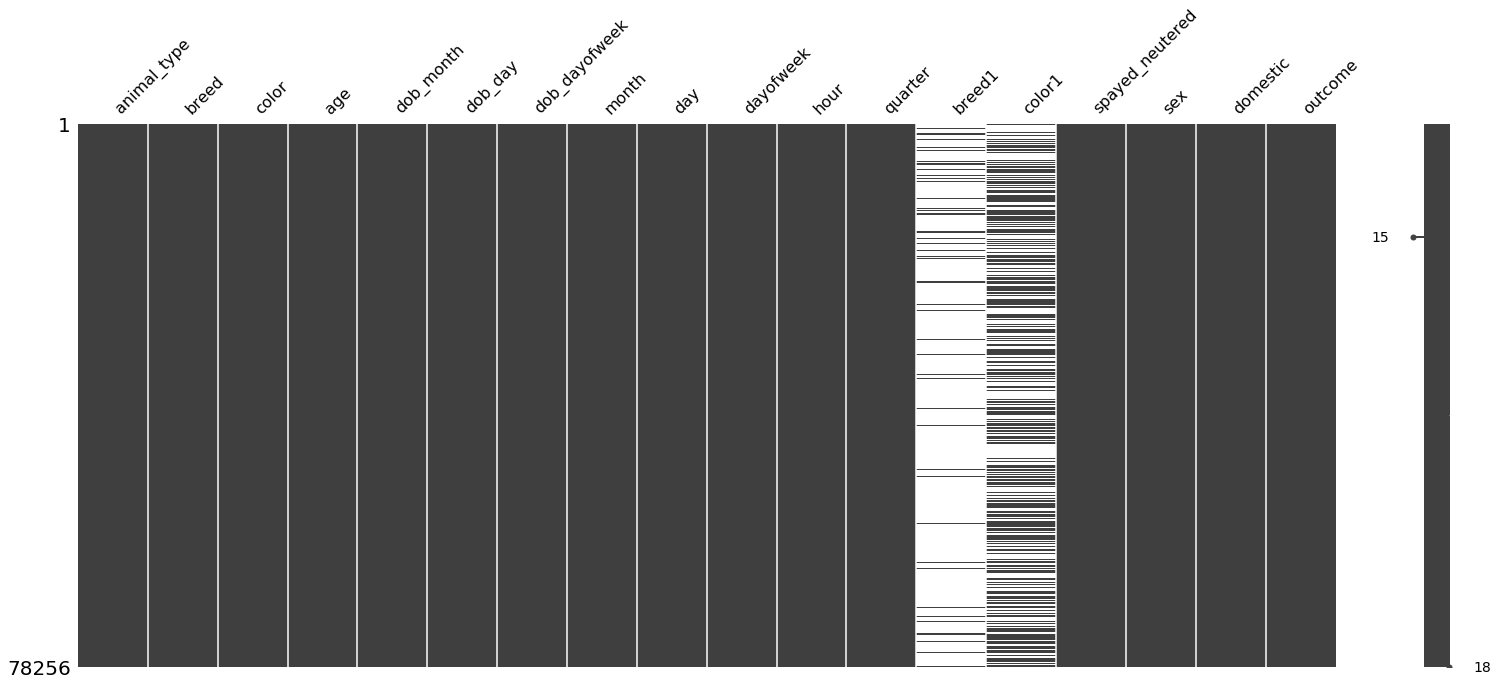

In [835]:
msno.matrix(cats )

In [6]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex','animal_type'])
cats_ohe.head()
out_t={'relocate_unknown':0,'euthanasia_court/investigation':0,'euthanasia_behavior':0,'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 0, 'euthanasia_at-vet' : 0, 'adoption_foster' : 1, 'died_in-foster' : 0, 'transfer_scrp' : 0, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 1, 'missing_in-foster' : 0, 'adoption_offsite' : 1, 'adoption_unknown' :1,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}
#output is converted from string to catogries 0 to 5 represent each output
# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
X_test.drop(columns=['outcome'], inplace=True)
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
1   366         11        6              1     11    7          3    11   
2   429          3       31              6      6    3          1    14   
3  3300          6        2              3      6   15          6    15   
4   181          1        7              1      7    7          0    14   

   quarter  domestic        ...         spayed_neutered_True  \
0        3         1        ...                            0   
1        4         0        ...                            1   
2        2         0        ...                            1   
3        2         0        ...                            1   
4        3         0        ...                            0   

   spayed_neutered_unknown  sex_female  sex_male  sex_unknown  \
0                        0           0         1            0   
1                        0        

In [7]:
from sklearn import metrics as mt
from sklearn.preprocessing import OneHotEncoder
import keras
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [8]:
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_test_ar=X_test.values
y_test_ar=np.asarray(y_test)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)

print(x_train_ar.shape)
print(y_target_ar.shape)
unique, counts = np.unique(y_target_ar, return_counts=True)
np.asarray((unique, counts))

(62604, 473)
(62604,)


array([[    0,     1],
       [35934, 26670]], dtype=int64)

In [9]:

for i in range(78256):
 sex[0][i]=str(sex[0][i])


In [10]:
cats=cats.drop(columns=['color1'])
cats['spayed_neutered'] = sex[0]
cats=cats.dropna() 
cats=cats.drop(columns=['outcome'])
cats

,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,spayed_neutered,sex,domestic
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,False,male,1
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,True,female,0
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,True,male,0
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,True,male,0
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,unknown,unknown,0
5,Dog,leonberger,brown,126,6,3,0,10,7,0,13,4,False,male,0
6,Other,squirrel,tan,365,12,13,4,12,13,5,12,4,unknown,unknown,0
7,Dog,chihuahua shorthair,brown,1111,11,23,2,12,8,0,15,4,True,female,0
8,Cat,domestic shorthair,blue tabby,59,6,16,0,8,14,3,18,3,False,female,1
9,Cat,domestic shorthair,white,95,3,26,2,6,29,6,17,2,True,female,1


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
categorical_headers = ['animal_type','breed','color',
                       'spayed_neutered','sex']
numeric_headers = ["age", "dob_month", "dob_day","dob_dayofweek","month","day","dayofweek","hour","quarter"]
encoders = dict() 
for col in categorical_headers:
    cats[col] = cats[col].str.strip()

    encoders[col] = LabelEncoder() # save the encoder
    cats[col+'_int'] = encoders[col].fit_transform(cats[col])
for col in numeric_headers:
    cats[col] = cats[col].astype(np.float)
    
    
    ss = StandardScaler()
    cats[col] = ss.fit_transform(cats[col].values.reshape(-1, 1))


In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
X_train, X_test, y_train, y_test=train_test_split(cats, outcome, test_size=0.2)

print(X_train.shape)
print(X_test.shape)


(62604, 20)
(15652, 20)


In [13]:

ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[categorical_headers].values)
X_test_ohe = ohe.fit_transform(X_test[categorical_headers].values)

print(X_test_ohe.shape)
print(X_train_ohe.shape)

(15652, 328)
(62604, 401)


In [14]:
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])



In [15]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train_ar =  ss.fit_transform(X_train[feature_columns].values).astype(np.float32)
X_test_ar =  ss.transform(X_test[feature_columns].values).astype(np.float32)

y_train_ar = np.asarray(y_train)
y_test_ar = np.asarray(y_test)

print(feature_columns)

['animal_type_int', 'breed_int', 'color_int', 'spayed_neutered_int', 'sex_int', 'age', 'dob_month', 'dob_day', 'dob_dayofweek', 'month', 'day', 'dayofweek', 'hour', 'quarter']


In [40]:
# create sparse input branch for ohe
from keras.layers import concatenate
from keras import backend as K



def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=100, activation='relu', name='ohe_1')(inputsSparse)
xSparse1 = Dense(units=50, activation='relu', name='ohe_2')(xSparse)
# create dense input branch for numeric
inputsDense = Input(shape=(X_train_ar.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=100, activation='relu',name='num_1')(inputsDense)
xDense1 = Dense(units=50, activation='relu',name='num_2')(xDense)
x = concatenate([xSparse1, xDense1], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ohe (InputLayer)              (None, 401)          0                                            
__________________________________________________________________________________________________
X_Numeric (InputLayer)          (None, 14)           0                                            
__________________________________________________________________________________________________
ohe_1 (Dense)                   (None, 100)          40200       X_ohe[0][0]                      
__________________________________________________________________________________________________
num_1 (Dense)                   (None, 100)          1500        X_Numeric[0][0]                  
__________________________________________________________________________________________________
ohe_2 (Den

In [39]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

model.fit([ X_train_ohe, X_train_ar ], # inputs for each branch are a list
          y_train, 
          epochs=20, 
          batch_size=50, 
          verbose=0)


NameError: name 'f1_score' is not defined

In [27]:
yhat = model.predict([X_train_ohe,
                      X_train_ar]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_train_ar,yhat),mt.accuracy_score(y_train_ar,yhat))


[[28433  7597]
 [ 5777 20797]] 0.7863714778608396


In [31]:
recall = model.evaluate([ X_train_ohe, X_train_ar ], y_train_ar, verbose=0)
recall

[0.14076775581484352, 0.794214427196959, 0.7721247099267127]

In [865]:

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) 
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),sparse=False, name='numeric'))
x = Dense(units=100, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=50,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
animal_type_int (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
breed_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
color_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
spayed_neutered_int (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
sex_int (I

In [866]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_ar], # create a list of inputs for embeddings
        y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
62604/62604 [==============================] - 5s 84us/step - loss: 0.2080 - acc: 0.6802
Epoch 2/20
62604/62604 [==============================] - 4s 69us/step - loss: 0.1692 - acc: 0.7576
Epoch 3/20
62604/62604 [==============================] - 5s 73us/step - loss: 0.1563 - acc: 0.7687
Epoch 4/20
62604/62604 [==============================] - 6s 89us/step - loss: 0.1527 - acc: 0.7728
Epoch 5/20
62604/62604 [==============================] - 5s 76us/step - loss: 0.1510 - acc: 0.7751
Epoch 6/20
62604/62604 [==============================] - 5s 80us/step - loss: 0.1498 - acc: 0.7771
Epoch 7/20
62604/62604 [==============================] - 5s 81us/step - loss: 0.1488 - acc: 0.7790
Epoch 8/20
62604/62604 [==============================] - 5s 81us/step - loss: 0.1480 - acc: 0.7809
Epoch 9/20
62604/62604 [==============================] - 5s 86us/step - loss: 0.1472 - acc: 0.7820
Epoch 10/20
62604/62604 [==============================] - 5s 84us/step - loss: 0.1466 - acc: 0.7834

In [867]:
yhat = np.round(model.predict(X_ints_test + [X_test_ar]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[7203 1796]
 [1503 5150]] 0.7892282136468183


## Model cross_columns1

In [42]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



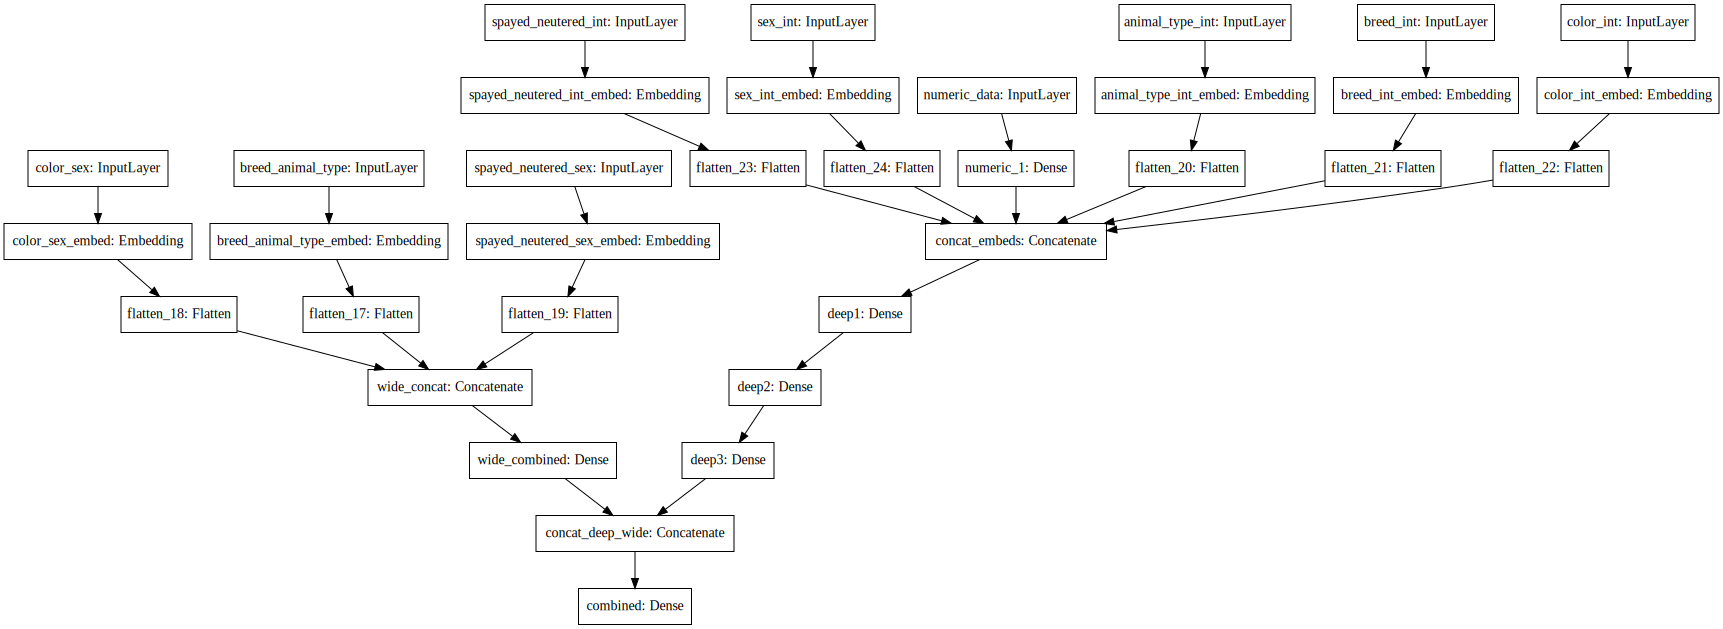

In [43]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [44]:
#%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30, 
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 5s 76us/step - loss: 0.1525 - acc: 0.7713 - f1_m: 0.7327 - val_loss: 0.1476 - val_acc: 0.7789 - val_f1_m: 0.7468
Epoch 2/30
62604/62604 [==============================] - 3s 49us/step - loss: 0.1446 - acc: 0.7845 - f1_m: 0.7442 - val_loss: 0.1455 - val_acc: 0.7802 - val_f1_m: 0.7506
Epoch 3/30
62604/62604 [==============================] - 3s 50us/step - loss: 0.1420 - acc: 0.7901 - f1_m: 0.7503 - val_loss: 0.1434 - val_acc: 0.7843 - val_f1_m: 0.7442
Epoch 4/30
62604/62604 [==============================] - 3s 52us/step - loss: 0.1403 - acc: 0.7929 - f1_m: 0.7532 - val_loss: 0.1445 - val_acc: 0.7832 - val_f1_m: 0.7291
Epoch 5/30
62604/62604 [==============================] - 3s 53us/step - loss: 0.1388 - acc: 0.7953 - f1_m: 0.7570 - val_loss: 0.1419 - val_acc: 0.7887 - val_f1_m: 0.7520
Epoch 6/30
62604/62604 [==============================] - 4s 57us/step - loss: 0.1377 - acc: 0.

In [45]:
yhat = np.round(model.predict(X_ints_test + [X_test_ar]))
print(mt.confusion_matrix(y_test,yhat), mt.accuracy_score(y_test,yhat))

[[7180 1785]
 [1420 5267]] 0.7952338359315103


## Model cross_columns2

In [47]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['breed','sex'],
                 ['color', 'spayed_neutered']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model1 = Model(inputs=all_inputs, outputs=final_branch)



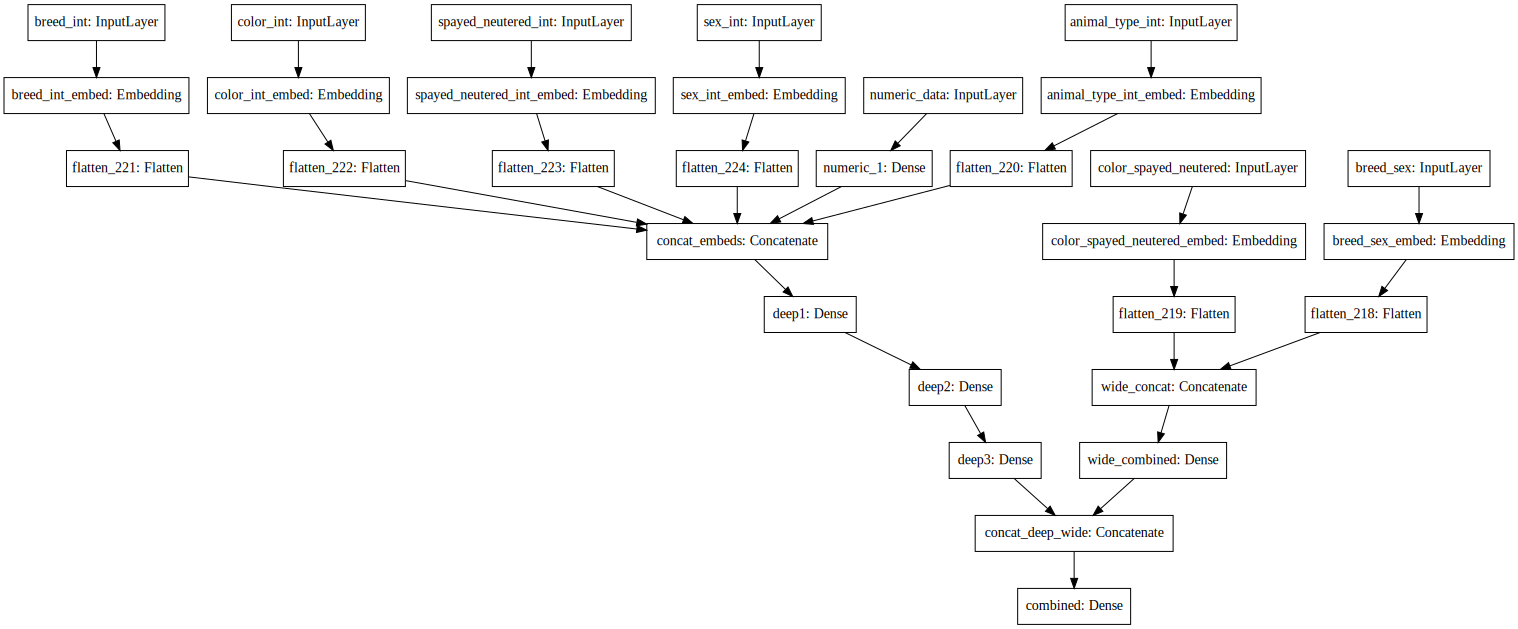

In [1027]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [48]:
%%time

model1.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history1 = model1.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 4s 71us/step - loss: 0.1526 - acc: 0.7718 - f1_m: 0.7304 - val_loss: 0.1473 - val_acc: 0.7800 - val_f1_m: 0.7376
Epoch 2/30
62604/62604 [==============================] - 3s 52us/step - loss: 0.1445 - acc: 0.7866 - f1_m: 0.7465 - val_loss: 0.1452 - val_acc: 0.7837 - val_f1_m: 0.7415
Epoch 3/30
62604/62604 [==============================] - 3s 51us/step - loss: 0.1419 - acc: 0.7910 - f1_m: 0.7503 - val_loss: 0.1434 - val_acc: 0.7864 - val_f1_m: 0.7545
Epoch 4/30
62604/62604 [==============================] - 3s 52us/step - loss: 0.1402 - acc: 0.7942 - f1_m: 0.7537 - val_loss: 0.1424 - val_acc: 0.7865 - val_f1_m: 0.7413
Epoch 5/30
62604/62604 [==============================] - 3s 56us/step - loss: 0.1389 - acc: 0.7960 - f1_m: 0.7554 - val_loss: 0.1414 - val_acc: 0.7885 - val_f1_m: 0.7512
Epoch 6/30
62604/62604 [==============================] - 4s 62us/step - loss: 0.1379 - acc: 0.

Text(0.5, 0, 'epochs Model 1')

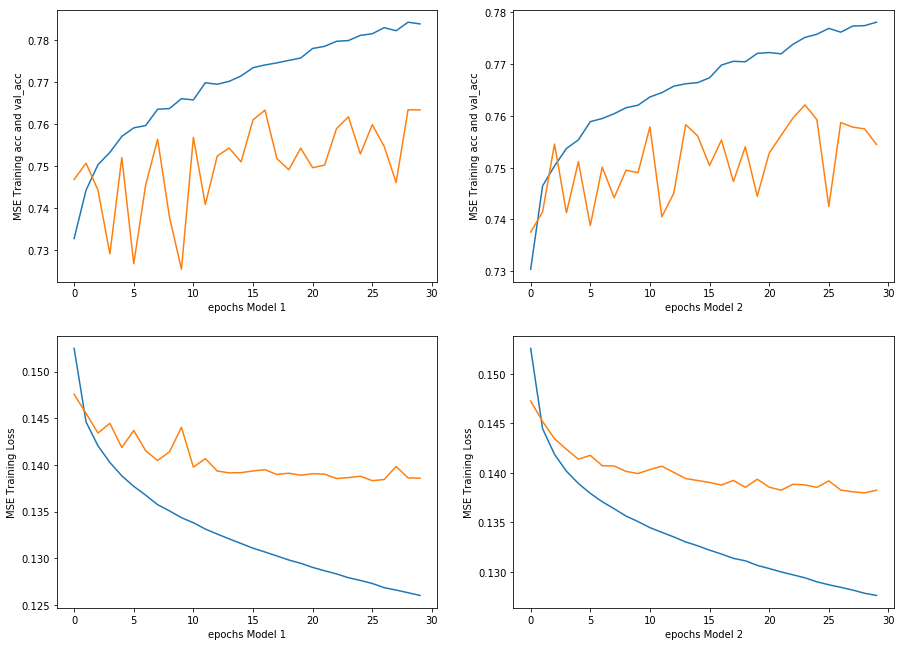

In [51]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,11))
plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model 2')
plt.plot(history1.history['f1_m'])
plt.plot(history1.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(history1.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs Model 2')
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs Model 2')



plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model 1')
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs Model 1')
plt.plot(history.history['val_loss'])
plt.xlabel('epochs Model 1')

Model 1 corsing 
 A-breed ,animal_type
 B-sex ,color
 C-sex, spayed_neutered

model 2 is crossing :
 A-breed,sex
 B-color', spayed_neutered


shown above the accuracy and the valdation for both model1 and model2 i want to argue that model 1 is slightly better than model2 because of the following reasons :

1- the elements model 1 is crossing are highly corrlated, females always have more colors , breed is highly colrated with animal type so it provide a better genrliztion  

2- because of the first point , model 1 resulted in a better over all accurace and valdation accuracy than model 2

3- best accracy for model1 is 0.7781 and validation is 0.7545


### Model A 5 layars

In [52]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'
cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]


#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=15,activation='relu', name='deep4')(deep_branch)   
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

modelA = Model(inputs=all_inputs, outputs=final_branch)

In [53]:
%%time

modelA.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyA = modelA.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 5s 82us/step - loss: 0.1528 - acc: 0.7702 - f1_m: 0.7313 - val_loss: 0.1494 - val_acc: 0.7779 - val_f1_m: 0.7306
Epoch 2/30
62604/62604 [==============================] - 4s 70us/step - loss: 0.1455 - acc: 0.7843 - f1_m: 0.7448 - val_loss: 0.1461 - val_acc: 0.7808 - val_f1_m: 0.7415
Epoch 3/30
62604/62604 [==============================] - 5s 80us/step - loss: 0.1433 - acc: 0.7877 - f1_m: 0.7469 - val_loss: 0.1452 - val_acc: 0.7830 - val_f1_m: 0.7506
Epoch 4/30
62604/62604 [==============================] - 4s 71us/step - loss: 0.1417 - acc: 0.7908 - f1_m: 0.7510 - val_loss: 0.1450 - val_acc: 0.7844 - val_f1_m: 0.7378
Epoch 5/30
62604/62604 [==============================] - 5s 73us/step - loss: 0.1405 - acc: 0.7927 - f1_m: 0.7527 - val_loss: 0.1448 - val_acc: 0.7849 - val_f1_m: 0.7587
Epoch 6/30
62604/62604 [==============================] - 5s 83us/step - loss: 0.1395 - acc: 0.

### Model B 7 layers

In [77]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]




# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')

wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=200,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=100,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep4')(deep_branch) 
deep_branch = Dense(units=15,activation='relu', name='deep5')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep6')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

modelB = Model(inputs=all_inputs, outputs=final_branch)



In [65]:
%%time

modelB.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyB = modelB.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 6s 95us/step - loss: 0.1524 - acc: 0.7715 - f1_m: 0.7256 - val_loss: 0.1473 - val_acc: 0.7793 - val_f1_m: 0.7389
Epoch 2/30
62604/62604 [==============================] - 4s 70us/step - loss: 0.1439 - acc: 0.7872 - f1_m: 0.7473 - val_loss: 0.1444 - val_acc: 0.7849 - val_f1_m: 0.7484
Epoch 3/30
62604/62604 [==============================] - 4s 69us/step - loss: 0.1408 - acc: 0.7919 - f1_m: 0.7531 - val_loss: 0.1420 - val_acc: 0.7897 - val_f1_m: 0.7500
Epoch 4/30
62604/62604 [==============================] - 5s 75us/step - loss: 0.1388 - acc: 0.7954 - f1_m: 0.7569 - val_loss: 0.1414 - val_acc: 0.7919 - val_f1_m: 0.7509
Epoch 5/30
62604/62604 [==============================] - 5s 73us/step - loss: 0.1371 - acc: 0.7977 - f1_m: 0.7588 - val_loss: 0.1414 - val_acc: 0.7897 - val_f1_m: 0.7523
Epoch 6/30
62604/62604 [==============================] - 5s 74us/step - loss: 0.1359 - acc: 0.

Text(0.5, 0, 'epochs Model B')

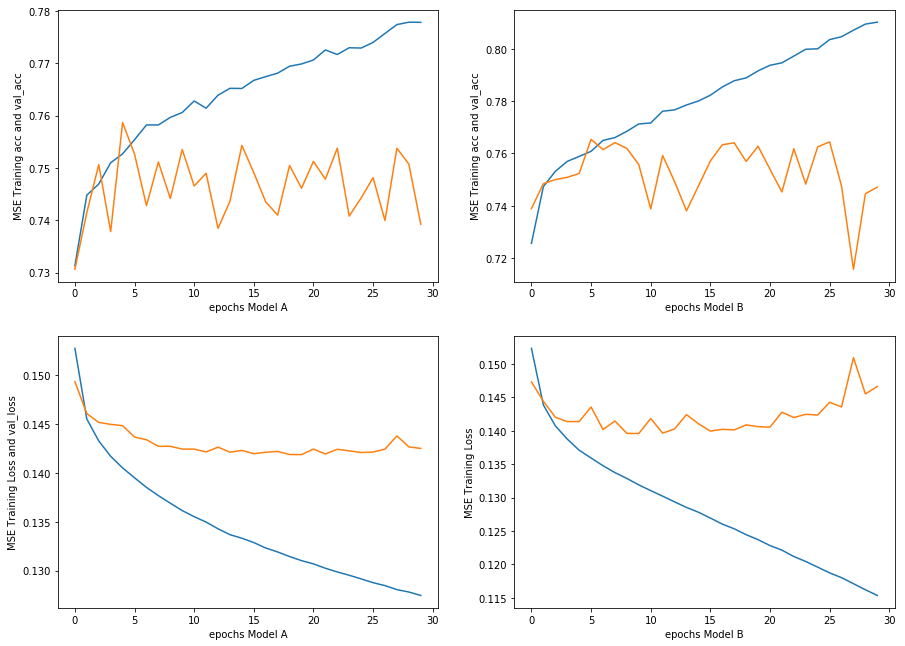

In [66]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model A')
plt.plot(historyA.history['f1_m'])

plt.plot(historyA.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(historyA.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyA.history['val_loss'])
plt.xlabel('epochs Model A')


plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model B')
plt.plot(historyB.history['f1_m'])
plt.plot(historyB.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(historyB.history['loss'])
plt.ylabel('MSE Training Loss')
plt.plot(historyB.history['val_loss'])
plt.xlabel('epochs Model B')

model A and model B has diffrent number of layers :

1- Model A has 5 layers 

2- model B has 7 layers, 


model B seems to have a better accuracy that reached as high as 81 % but on the other hand the valdation loss got higher and higher and resulted in a loss valdation accuracy and the reasone behind that is an over fit accured because of the high number of layers ,

so i would say Modle B provided a better F1 accurace with a minmum valdation loss for itration bellow 15 epcos thus model B is better than model A only if we reduced the number of epocs to 15 which in turns increase the time effecance 



### MLP

In [145]:
inputs = Input(shape=(X_train_ar.shape[1],))
x = Dense(units=100, activation='relu')(inputs)
x = Dense(units=50, activation='relu')(x)
x = Dense(units=25, activation='relu')(x)
x = Dense(units=15, activation='relu')(x)
x = Dense(units=10, activation='relu')(x)
predictions = Dense(1,activation='sigmoid')(x)
modelMLP1 = Model(inputs=inputs, outputs=predictions)


In [146]:
modelMLP1.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

modelMLP1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_15 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_16 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total para

In [147]:
historyMLP1 = modelMLP1.fit(X_train_ar,
                    y_train, 
                    epochs=15, 
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_test_ar, y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/15
62604/62604 [==============================] - 4s 65us/step - loss: 0.2215 - acc: 0.6374 - f1_m: 0.3856 - val_loss: 0.1981 - val_acc: 0.7060 - val_f1_m: 0.6133
Epoch 2/15
62604/62604 [==============================] - 3s 43us/step - loss: 0.1748 - acc: 0.7461 - f1_m: 0.6881 - val_loss: 0.1618 - val_acc: 0.7623 - val_f1_m: 0.7231
Epoch 3/15
62604/62604 [==============================] - 3s 46us/step - loss: 0.1567 - acc: 0.7704 - f1_m: 0.7377 - val_loss: 0.1561 - val_acc: 0.7676 - val_f1_m: 0.7278
Epoch 4/15
62604/62604 [==============================] - 3s 43us/step - loss: 0.1525 - acc: 0.7762 - f1_m: 0.7442 - val_loss: 0.1534 - val_acc: 0.7725 - val_f1_m: 0.7317
Epoch 5/15
62604/62604 [==============================] - 3s 49us/step - loss: 0.1501 - acc: 0.7779 - f1_m: 0.7449 - val_loss: 0.1508 - val_acc: 0.7745 - val_f1_m: 0.7454
Epoch 6/15
62604/62604 [==============================] - 3s 52us/step - loss: 0.1484 - acc: 0.

In [78]:
%%time

modelB.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyB = modelB.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=15,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/15
62604/62604 [==============================] - 6s 89us/step - loss: 0.1525 - acc: 0.7716 - f1_m: 0.7288 - val_loss: 0.1476 - val_acc: 0.7801 - val_f1_m: 0.7392
Epoch 2/15
62604/62604 [==============================] - 4s 62us/step - loss: 0.1452 - acc: 0.7836 - f1_m: 0.7414 - val_loss: 0.1450 - val_acc: 0.7845 - val_f1_m: 0.7469
Epoch 3/15
62604/62604 [==============================] - 4s 67us/step - loss: 0.1425 - acc: 0.7885 - f1_m: 0.7486 - val_loss: 0.1438 - val_acc: 0.7855 - val_f1_m: 0.7522
Epoch 4/15
62604/62604 [==============================] - 4s 66us/step - loss: 0.1406 - acc: 0.7928 - f1_m: 0.7552 - val_loss: 0.1438 - val_acc: 0.7858 - val_f1_m: 0.7416
Epoch 5/15
62604/62604 [==============================] - 4s 68us/step - loss: 0.1391 - acc: 0.7951 - f1_m: 0.7571 - val_loss: 0.1435 - val_acc: 0.7844 - val_f1_m: 0.7576
Epoch 6/15
62604/62604 [==============================] - 4s 69us/step - loss: 0.1376 - acc: 0.

In [97]:
from sklearn import metrics as mt
yhat_proba = modelMLP1.predict(X_test_ar)
yhatMLP = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhatMLP),mt.accuracy_score(y_test,yhat))


from sklearn import metrics as mt
yhat_proba1 = modelB.predict(X_ints_test+ [X_test_ar])
yhatB = np.round(yhat_proba1)
print(mt.confusion_matrix(y_test,yhatB),mt.accuracy_score(y_test,yhatB))

[[7210 1755]
 [1550 5137]] 0.7888448760541784
[[7360 1605]
 [1647 5040]] 0.7922310247891643


Text(0.5, 0, 'epochs MLP')

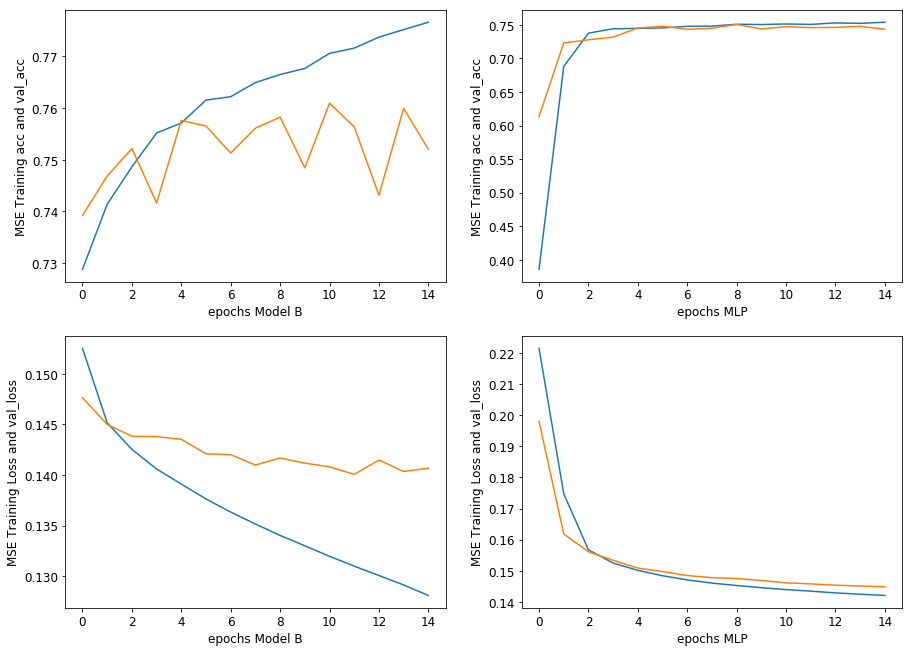

In [148]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model B')
plt.plot(historyB.history['f1_m'])

plt.plot(historyB.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(historyB.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyB.history['val_loss'])
plt.xlabel('epochs Model B')


plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs MLP')
plt.plot(historyMLP1.history['f1_m'])

plt.plot(historyMLP1.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(historyMLP1.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyMLP1.history['val_loss'])
plt.xlabel('epochs MLP')

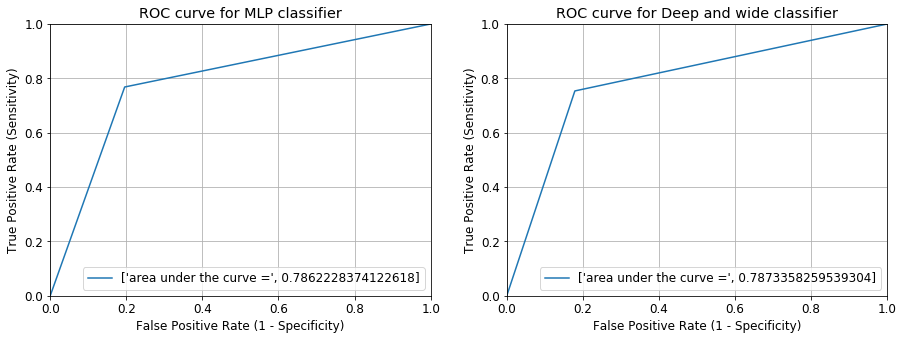

In [149]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhatMLP)
AUCMLP=metrics.roc_auc_score(y_test, yhatMLP)
AUCB=metrics.roc_auc_score(y_test, yhatB)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr,label= ['area under the curve =',AUCMLP])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for MLP classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhatB)
plt.subplot(1,2,2)
plt.plot(fpr, tpr,label= ['area under the curve =',AUCB])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Deep and wide classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

the plots above compares MLP with our best Deep and wide model we found the fellowing observation :

1- f1_ score for our Deep model is higher than the MLP

2- the f1 valdation accuracy for deep is slightly better on avrage  than the MLP

3- the big difrance between both our deep model and the MLP, that there is big gab between the valdation accurace and the accuracy , in my opinion since deep network is better at genrlizing and wide network is better at memoriztion so : 
 A- the deep and wide model did so good with the test data so its vary genral to it
 B- on the other hand the deep network had same results for both the training nd the test data which means that it better predicted our data set using only memoriztion 
 
 i would argue that for this data set an Modle B did slightly better that the MLP as seen from the area under the curve value on the plots